# Прогнозирование количества заказов такси

## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### План работы над проектом

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

## Предобработка данных

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_score, GridSearchCV, TimeSeriesSplit, train_test_split

from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import OrdinalEncoder, StandardScaler

from sklearn.pipeline import Pipeline

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid") 

from statsmodels.tsa.stattools import adfuller
import time
from functools import partial
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("/datasets/taxi.csv", parse_dates=[0], index_col=[0])
df.sort_index(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [3]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


### Построим графики

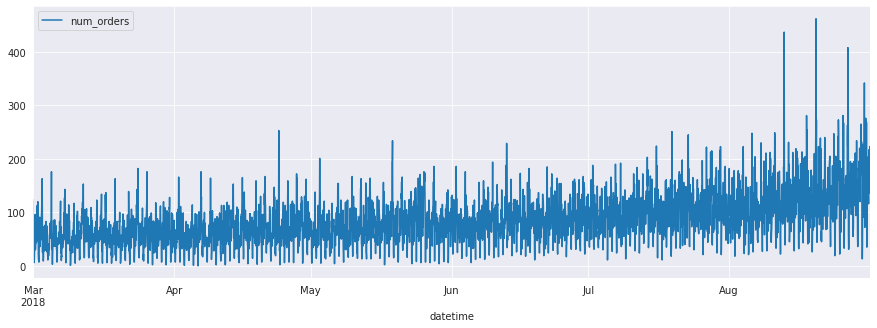

In [4]:
df = df.resample('1H').sum()

# построим график
size = (15,5)
df.plot(figsize=size);

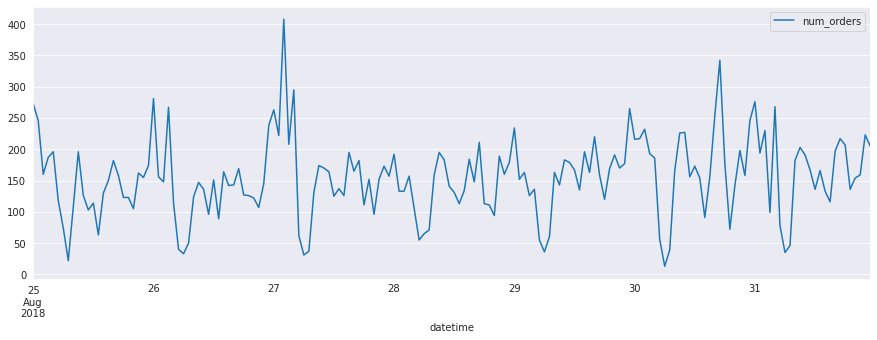

In [5]:
# посмотрим данные по последней неделе
df['2018-08-25':'2018-08-31'].plot(figsize=size);

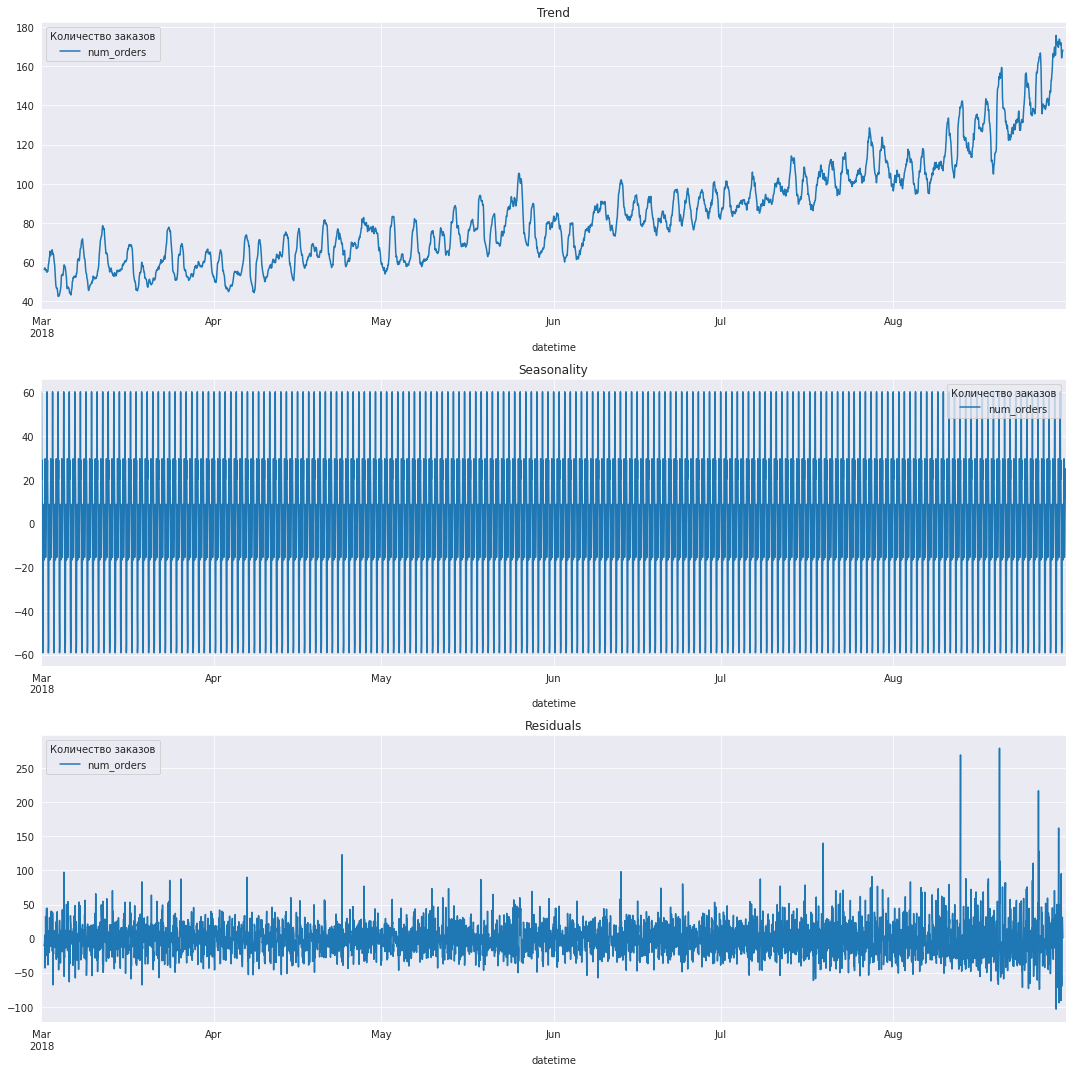

In [241]:
# изучим тернды и сезонность
decomposed_df = seasonal_decompose(df)

plt.figure(figsize=(15,15))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его оси ax, равными plt.gca()
decomposed_df.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.legend(title="Количество заказов")
plt.subplot(312)
decomposed_df.seasonal.plot(ax=plt.gca(), label='Количество заказов')
plt.title('Seasonality')
plt.legend(title="Количество заказов")
plt.subplot(313)
decomposed_df.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.legend(title="Количество заказов")                
plt.tight_layout()

Посмотрим тоже самое за неделю с понедельника 22 августа по 28 августа. Чтобы посмотреть предшествующий тренд, посмотрим с 21го числа.

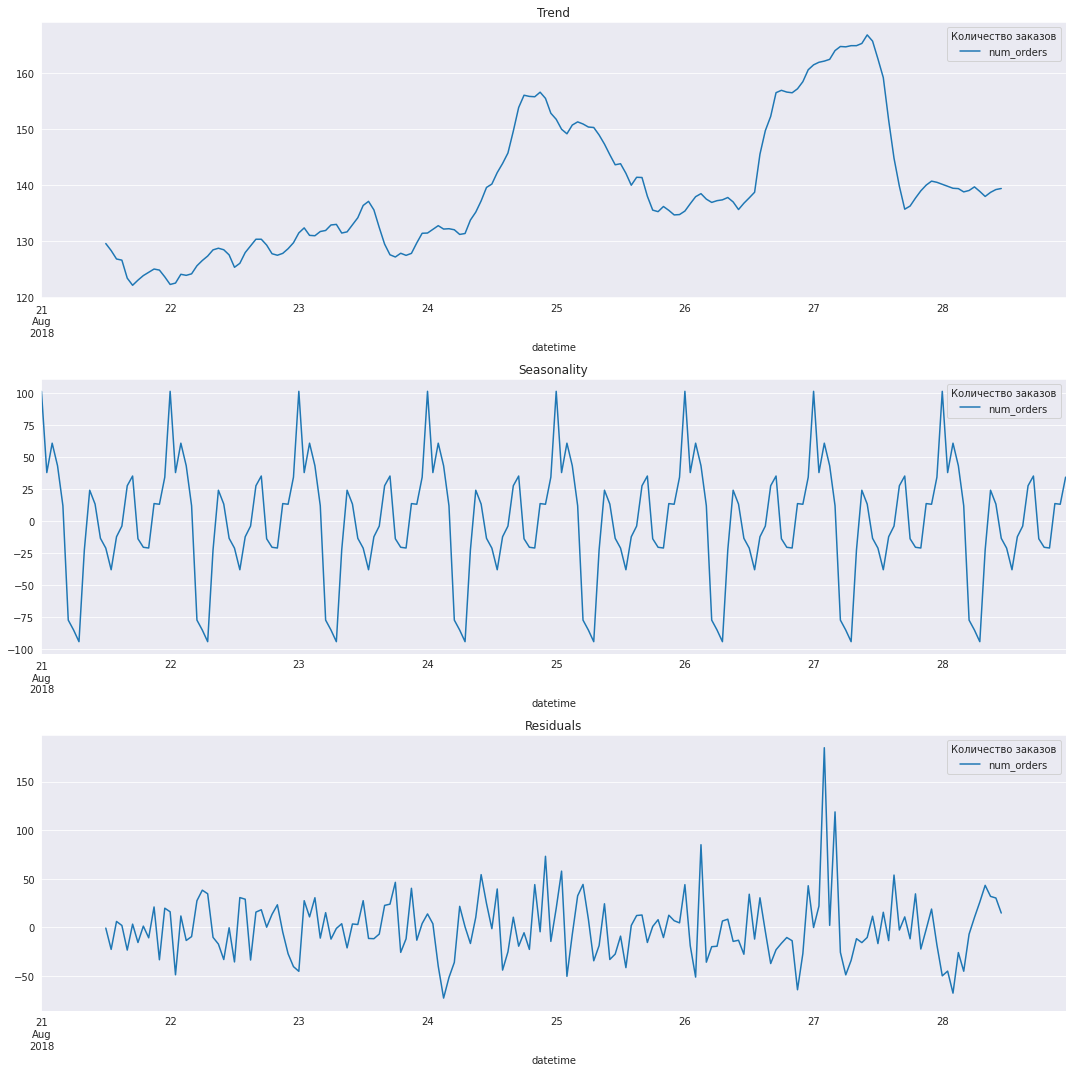

In [242]:
decomposed_last_week = seasonal_decompose(df['2018-08-21':'2018-08-28'])

plt.figure(figsize=(15,15))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его оси ax, равными plt.gca()
decomposed_last_week.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.legend(title="Количество заказов")
plt.subplot(312)
decomposed_last_week.seasonal.plot(ax=plt.gca(), label='Количество заказов')
plt.title('Seasonality')
plt.legend(title="Количество заказов")
plt.subplot(313)
decomposed_last_week.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.legend(title="Количество заказов")                
plt.tight_layout()

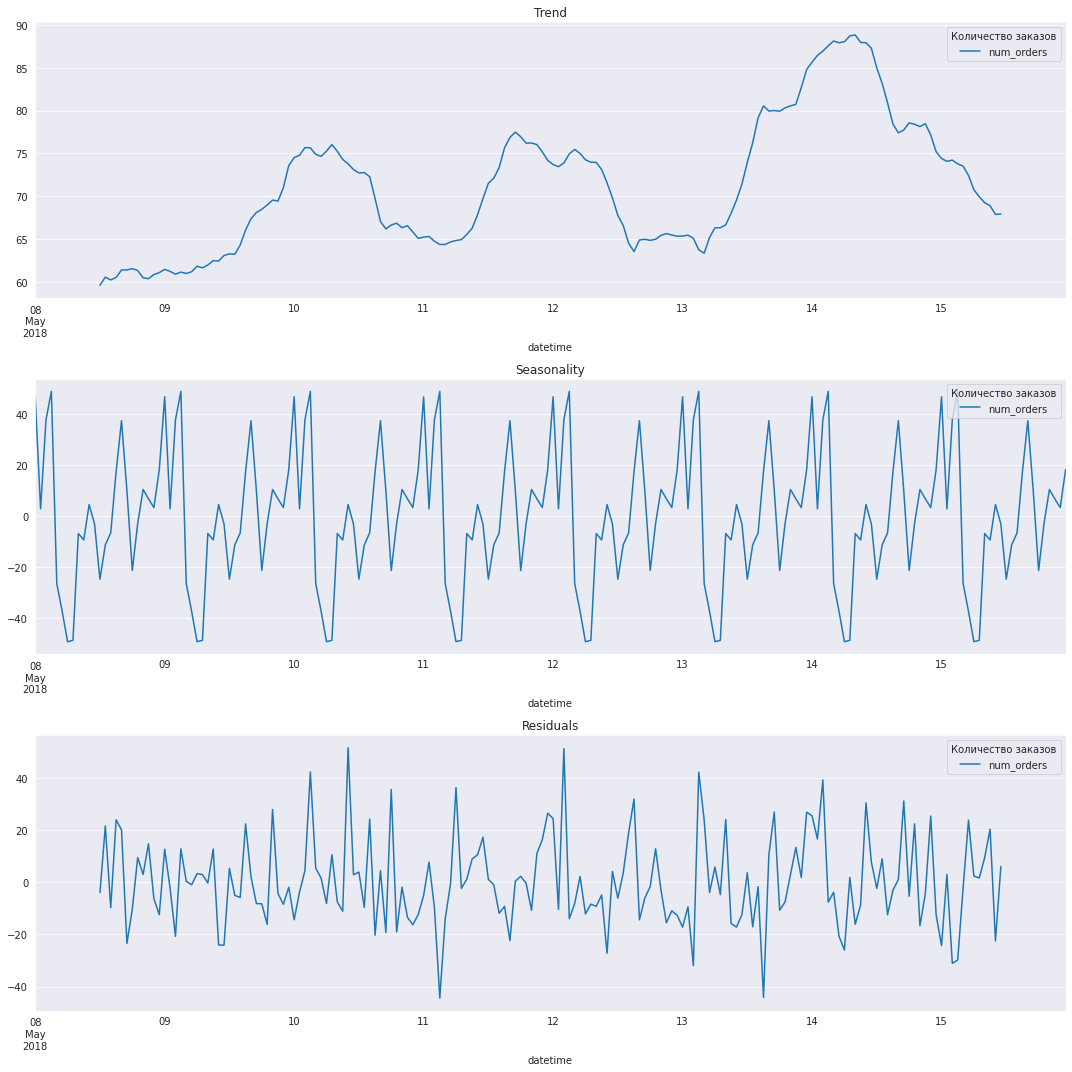

In [243]:
# с 8 по 15 мая
decomposed_last_week = seasonal_decompose(df['2018-05-08':'2018-05-15'])

plt.figure(figsize=(15,15))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его оси ax, равными plt.gca()
decomposed_last_week.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.legend(title="Количество заказов")
plt.subplot(312)
decomposed_last_week.seasonal.plot(ax=plt.gca(), label='Количество заказов')
plt.title('Seasonality')
plt.legend(title="Количество заказов")
plt.subplot(313)
decomposed_last_week.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.legend(title="Количество заказов")                
plt.tight_layout()

- Дисперсия ряда со временем увеличивается.
- По тренду видно, что со временем все больше людей пользуется услугой заказа такси.
- Каждый день видно, что такси требуются для ночных рейсов и по наступлению утра намечается спад вызовов такси.
- Также видно, что с воскресенья на понедельник спрос снижается и становится большим в середине недели. Потом немного падает к пянице и снова начинает подниматься до воскресенья.

Временной ряд подвержен тренду, который меняется во времени.  
Является ли он стационарным можно проверить критерием Дики-Фуллера.

**Нулевая гипотеза:** *"Временной ряд является нестацинарным"*.  
**Альтернативная гипотеза:** *"Временной ряд стационарен"*

In [244]:
print('P =', adfuller(df['num_orders'])[1])
if adfuller(df['num_orders'])[1] < 0.05:
    print('Нулевая гипотеза отвергается. Ряд стационарен по критерию Дики-Фуллера')
else:
    print('Нулевая гипотеза не отвергается. Ряд нестационарен по критерию Дики-Фуллера')

P = 0.02894005140261338
Нулевая гипотеза отвергается. Ряд стационарен по критерию Дики-Фуллера


При явном наличии тренда и сезонности, критерий Дики-Фуллера не значим.

### Исследуем признаки

1. Так как видна ежедневная сезонность -  признак *day*.
2. Тренд показывает, что к концу недели и в середине идет увеличение заказов - признак *dayofweek*.
3. Из месяца в месяц данные отличаются и носят цикличный характер - признак *month*.
4. Для определения количества *lag* признаков найдем разницу в часах между максимальным пиком ночью и минимальным пиком в сезонном сегменте.
5. Для ширины окна *rolling_mean* проверим, какое окно в скользяще среднем лучше всего напоминает данные.

In [245]:
# проверим коллеляцию датафрейма с датафреймом со сдвигом на:
# 1 час, 2 часа, 3 часа, 4 часа, 23 часа, сутки, 2 дня, неделя, 2 недели, месяц
for i in (1, 2, 3, 4, 23, 24, 48, 168, 336, 730):
  print(i, '-', pd.concat([
                df['num_orders'],
                df['num_orders'].shift(i)
                ], axis=1).corr().iloc[0,1])

1 - 0.6241382244677501
2 - 0.46544368563718735
3 - 0.3211728065428701
4 - 0.24879053634205409
23 - 0.5569941285394129
24 - 0.691575709178353
48 - 0.724817635915348
168 - 0.8055687597966542
336 - 0.7706264868357534
730 - 0.15706560351453677


In [246]:
max_lag = 168

In [247]:
# подберем ширину окна
rolling_mean_size_dict = {}
for rolling_mean_size in range(2,49):
    data = df.copy()
    data['rolling_mean'] = data['num_orders'].rolling(rolling_mean_size).mean() 
    data.dropna(inplace=True)
    index = data.index
    num_orders = data['num_orders']
    rolling_mean = data['rolling_mean']
    RMSE = mean_squared_error(num_orders, rolling_mean) **0.5
    rolling_mean_size_dict[rolling_mean_size] = RMSE

rolling_mean_size = min(rolling_mean_size_dict.keys(), key=(lambda x: rolling_mean_size_dict[x]))
rolling_mean_size

2

### Создадим признаки для обучения модели

Самое точное - предсказывать значение не за предыдущий час, а за 168 ч, т.е. в тот день, тот же час на прошлой неделе.

In [248]:
 def make_features(data, column, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['month'] = data.index.month
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data[column].shift(lag)

    data['rolling_mean'] = data[column].shift().rolling(rolling_mean_size).mean()

In [249]:
make_features(df,'num_orders', max_lag, rolling_mean_size)

train, test = train_test_split(df, shuffle=False, test_size=0.1, random_state=8726)
train = train.dropna()

train_features = train.drop('num_orders', axis=1)
train_target = train['num_orders']
test_features = test.drop('num_orders', axis=1)
test_target = test['num_orders']

Создадим cv выборку для временных рядов через TimeSeriesSplit.

In [250]:
tscv = TimeSeriesSplit(n_splits = 10, max_train_size = (train.shape[0] * 4 //5))

def cv_time_series_rmse(regressor, data, n_splits=tscv.n_splits, max_train_size=tscv.max_train_size):
    RMSE = 0.0
    for train_index, test_index in tscv.split(data):
        train = data.iloc[train_index]
        test = data.iloc[test_index]
        train_features = train.drop('num_orders', axis=1)
        train_target = train['num_orders']
        test_features = test.drop('num_orders', axis=1)
        test_target = test['num_orders']
        regressor.fit(train_features, train_target)
        RMSE += mean_squared_error(test_target, regressor.predict(test_features)) ** 0.5
    return RMSE / n_splits

**Вывод**

1. Данные были проанализированы.
2. Были выявлены тренды и сезонность.
3. Данные были подготовлены к обучению.
4. Создана функция для кроссвалидации временных рядов.

## Обучение

Выберем следующие регрессоры для обучения модели:

- LinearRegression  
- Ridge  
- DecisionTreeRegressor  
- Lasso
- RabdomForestRegressor
- CatBoostRegressor
- LGBMRegressor

### Линейная регрессия

In [251]:
%%time

start_time = time.time()

regressor = LinearRegression()
cv_RMSE_LR = cv_time_series_rmse(regressor, train)

current_time = time.time()
cv_RMSE_LR_t = current_time-start_time
print(f'RMSE модели на обучающей выборке = {cv_RMSE_LR}\n')

RMSE модели на обучающей выборке = 288878204134.5992

CPU times: user 624 ms, sys: 679 ms, total: 1.3 s
Wall time: 733 ms


In [252]:
%%time


regressor = LinearRegression()
scaller = StandardScaler()
pipeline = Pipeline([("standard_scaller", scaller),("linear_regression", regressor)])
cv_RMSE_LR_S = cv_time_series_rmse(pipeline, train)
print(f'RMSE с использовнием StandardScaler = {cv_RMSE_LR_S}\n')

RMSE с использовнием StandardScaler = 3609284416009.8076

CPU times: user 768 ms, sys: 851 ms, total: 1.62 s
Wall time: 874 ms


Масштабирование признаков не влияет. Не будем применять масштаб.

### Ridge

Проведем кроссвалидацию для следующих моделей в два шага:

1. С помощью GridSearchCV найдем лучший параметр.
2. Используя cv_time_series_rmse получить результат кроссвалидации на временном ряду.

In [253]:
%%time

start_time = time.time()

regressor = Ridge(random_state=8726)
hyperparams = {'solver': ['auto', 'svd', 'cholesky', 'lsqr','sparse_cg'],
              'alpha': [0.001 , 0.01 , 0.1 , 1 , 10, 100, 1000, 10000]}

print('Подбор параметров для RMSE\n')
clf = GridSearchCV(regressor, hyperparams, cv=tscv.n_splits, scoring='neg_mean_squared_error')
clf.fit(train_features, train_target)
best_params_R = clf.best_params_
print(f'Лучший набор параметров, найденный в наборе:\n{best_params_R}\n')
print('Grid scores:\n')
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print('%0.6f for %r'% ((mean*-1)** 0.5, params))
print()

cv_RMSE_R = (max(means)*-1) ** 0.5

current_time = time.time()
gcv_RMSE_R_t = current_time-start_time
print(f'RMSE модели на обучающей выборке = {cv_RMSE_R}\n')

Подбор параметров для RMSE

Лучший набор параметров, найденный в наборе:
{'alpha': 10000, 'solver': 'lsqr'}

Grid scores:

21.374607 for {'alpha': 0.001, 'solver': 'auto'}
21.374607 for {'alpha': 0.001, 'solver': 'svd'}
21.374607 for {'alpha': 0.001, 'solver': 'cholesky'}
21.361118 for {'alpha': 0.001, 'solver': 'lsqr'}
21.371926 for {'alpha': 0.001, 'solver': 'sparse_cg'}
21.374604 for {'alpha': 0.01, 'solver': 'auto'}
21.374604 for {'alpha': 0.01, 'solver': 'svd'}
21.374604 for {'alpha': 0.01, 'solver': 'cholesky'}
21.361118 for {'alpha': 0.01, 'solver': 'lsqr'}
21.371928 for {'alpha': 0.01, 'solver': 'sparse_cg'}
21.374577 for {'alpha': 0.1, 'solver': 'auto'}
21.374577 for {'alpha': 0.1, 'solver': 'svd'}
21.374577 for {'alpha': 0.1, 'solver': 'cholesky'}
21.361118 for {'alpha': 0.1, 'solver': 'lsqr'}
21.371929 for {'alpha': 0.1, 'solver': 'sparse_cg'}
21.374306 for {'alpha': 1, 'solver': 'auto'}
21.374306 for {'alpha': 1, 'solver': 'svd'}
21.374306 for {'alpha': 1, 'solver': 'choles

In [254]:
%%time

start_time = time.time()

regressor = Ridge(random_state=8726)
regressor.set_params(**best_params_R)
cv_RMSE_R = cv_time_series_rmse(regressor, train)

current_time = time.time()
cv_RMSE_R_t = current_time-start_time
print(f'RMSE модели на обучающей выборке = {cv_RMSE_R}\n')

RMSE модели на обучающей выборке = 22.213718828369146

CPU times: user 368 ms, sys: 295 ms, total: 662 ms
Wall time: 689 ms


### DecisionTreeRegressor

In [255]:
%%time

start_time = time.time()

regressor = DecisionTreeRegressor(criterion='mse' , random_state=8726) 
hyperparams = {'max_depth': [8 , 10 , 12 , 15 , 20 , 25], 
               'min_samples_leaf': [10 , 20 , 50 , 100 , 200 , 500]}

print('Подбор параметров для RMSE\n')
clf = GridSearchCV(regressor, hyperparams, cv=tscv.n_splits, scoring='neg_mean_squared_error')
clf.fit(train_features, train_target)
best_params_DTR = clf.best_params_
print(f'Лучший набор параметров, найденный в наборе:\n{best_params_DTR}\n')
print('Grid scores:\n')
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_DTR = (max(means)*-1) ** 0.5

current_time = time.time()
gcv_RMSE_DTR_t = current_time-start_time
print(f'RMSE модели на для обучающей выборке = {cv_RMSE_DTR}\n')

Подбор параметров для RMSE

Лучший набор параметров, найденный в наборе:
{'max_depth': 8, 'min_samples_leaf': 100}

Grid scores:

25.301594 for {'max_depth': 8, 'min_samples_leaf': 10}
25.109468 for {'max_depth': 8, 'min_samples_leaf': 20}
24.226994 for {'max_depth': 8, 'min_samples_leaf': 50}
24.052871 for {'max_depth': 8, 'min_samples_leaf': 100}
24.741437 for {'max_depth': 8, 'min_samples_leaf': 200}
26.842843 for {'max_depth': 8, 'min_samples_leaf': 500}
26.411719 for {'max_depth': 10, 'min_samples_leaf': 10}
25.496094 for {'max_depth': 10, 'min_samples_leaf': 20}
24.229137 for {'max_depth': 10, 'min_samples_leaf': 50}
24.052871 for {'max_depth': 10, 'min_samples_leaf': 100}
24.741437 for {'max_depth': 10, 'min_samples_leaf': 200}
26.842843 for {'max_depth': 10, 'min_samples_leaf': 500}
26.704222 for {'max_depth': 12, 'min_samples_leaf': 10}
25.559255 for {'max_depth': 12, 'min_samples_leaf': 20}
24.229137 for {'max_depth': 12, 'min_samples_leaf': 50}
24.052871 for {'max_depth': 12

In [256]:
%%time

start_time = time.time()

regressor = DecisionTreeRegressor(criterion='mse', random_state=8726) 
regressor.set_params(**best_params_DTR)
cv_RMSE_DTR = cv_time_series_rmse(regressor, train)

current_time = time.time()
cv_RMSE_DTR_t = current_time-start_time
print(f'RMSE модели на обучающей выборке = {cv_RMSE_DTR}\n')

RMSE модели на обучающей выборке = 25.480188126122318

CPU times: user 983 ms, sys: 5.93 ms, total: 989 ms
Wall time: 989 ms


### Lasso

In [257]:
%%time

start_time = time.time()

regressor = Lasso(normalize=True, random_state=8726)
hyperparams = {'alpha':[0.0001 , 0.001 , 0.01 , 0.1 , 1 , 10 , 100 , 1000 , 10000],
               'max_iter': [500, 600, 700, 900, 1000, 1100],
               'selection': ['cyclic', 'random']}

print('Подбор параметров для RMSE\n')
clf = GridSearchCV(regressor, hyperparams,cv=tscv.n_splits, scoring='neg_mean_squared_error')
clf.fit(train_features, train_target)
best_params_L = clf.best_params_
print(f'Лучший набор параметров, найденный в наборе:\n{clf.best_params_}\n')
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
cv_RMSE_L = (max(means)*-1) ** 0.5

current_time = time.time()
gcv_RMSE_L_t = current_time-start_time
print(f'RMSE модели на обучающей выборке = {cv_RMSE_L}\n')

Подбор параметров для RMSE

Лучший набор параметров, найденный в наборе:
{'alpha': 0.001, 'max_iter': 500, 'selection': 'random'}

RMSE модели на обучающей выборке = 21.212079470378537

CPU times: user 1min 46s, sys: 1min 13s, total: 2min 59s
Wall time: 1min 45s


In [258]:
%%time

start_time = time.time()

regressor = Lasso(normalize=True, random_state=8726)
regressor.set_params(**best_params_L)
cv_RMSE_L = cv_time_series_rmse(regressor, train)

current_time = time.time()
cv_RMSE_L_t = current_time-start_time
print(f'RMSE модели на обучающей выборке = {cv_RMSE_L}\n')

RMSE модели на обучающей выборке = 23.160763591776593

CPU times: user 1.03 s, sys: 904 ms, total: 1.94 s
Wall time: 1.02 s


### RandomForestRegressor

In [269]:
%%time

start_time = time.time()

regressor = RandomForestRegressor(criterion='mse', random_state=8726)
hyperparams = {'n_estimators':[100, 200, 300],
               'max_depth':[10, 15, 20]}

print('Подбор параметров для RMSE\n')
clf = GridSearchCV(regressor, hyperparams,cv=tscv.n_splits, scoring='neg_mean_squared_error')
clf.fit(train_features, train_target)
best_params_RFR = clf.best_params_
print(f'Лучший набор параметров, найденный в наборе:\n{clf.best_params_}\n')
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
cv_RMSE_RFR = (max(means)*-1) ** 0.5

current_time = time.time()
gcv_RMSE_RFR_t = current_time-start_time
print(f'RMSE модели на обучающей выборке = {cv_RMSE_RFR}\n')

Подбор параметров для RMSE

Лучший набор параметров, найденный в наборе:
{'max_depth': 10, 'n_estimators': 200}

RMSE модели на обучающей выборке = 41.77698002976537

CPU times: user 1min 24s, sys: 304 ms, total: 1min 25s
Wall time: 1min 28s


In [270]:
%%time

start_time = time.time()

regressor = RandomForestRegressor(criterion='mse', random_state=8726)
regressor.set_params(**best_params_RFR)
cv_RMSE_RFR = cv_time_series_rmse(regressor, train)

current_time = time.time()
cv_RMSE_RFR_t = current_time-start_time
print(f'RMSE модели на обучающей выборке = {cv_RMSE_RFR}\n')

RMSE модели на обучающей выборке = 22.044440687534944

CPU times: user 4min 23s, sys: 296 ms, total: 4min 23s
Wall time: 4min 32s


### CatBoostRegressor

In [271]:
%%time

start_time = time.time()

regressor = CatBoostRegressor(iterations=200, random_state=8726, verbose=False) 
hyperparams = {'learning_rate':[0.1, 0.5, 0.8]}

print('Подбор параметров для RMSE\n')
clf = GridSearchCV(regressor, hyperparams,cv=tscv.n_splits, scoring='neg_mean_squared_error')
clf.fit(train_features, train_target)
best_params_CBR = clf.best_params_
print(f'Лучший набор параметров, найденный в наборе:\n{clf.best_params_}\n')
print('Grid scores:\n')
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
cv_RMSE_CBR = (max(means)*-1) ** 0.5

current_time = time.time()
gcv_RMSE_CBR_t = current_time-start_time
print(f'RMSE модели для обучающей выборке = {cv_RMSE_CBR}\n')

Подбор параметров для RMSE

Лучший набор параметров, найденный в наборе:
{'learning_rate': 0.1}

Grid scores:

RMSE модели для обучающей выборке = 21.122739864538644

CPU times: user 8min 7s, sys: 5.42 s, total: 8min 12s
Wall time: 4min 15s


In [272]:
%%time

start_time = time.time()

regressor = CatBoostRegressor(iterations=200, random_state=8726, verbose=False) 
regressor.set_params(**best_params_CBR)
cv_RMSE_CBR = cv_time_series_rmse(regressor, train)

current_time = time.time()
cv_RMSE_CBR_t = current_time-start_time
print(f'RMSE модели на обучающей выборке = {cv_RMSE_CBR}\n')

RMSE модели на обучающей выборке = 21.91815176005477

CPU times: user 2min, sys: 1.49 s, total: 2min 2s
Wall time: 1min 3s


Для сравнения с найденными параметрами, изучим как CatBoostRegressor находит RMSE без указания параметров.

In [273]:
%%time

start_time = time.time()

regressor = CatBoostRegressor(verbose=False) 
cv_RMSE_CBR_no_params = cv_time_series_rmse(regressor, train)

current_time = time.time()
cv_RMSE_CBR_no_params_t = current_time-start_time
print(f'RMSE модели на обучающей выборке = {cv_RMSE_CBR_no_params}\n')

RMSE модели на обучающей выборке = 21.615305439127397

CPU times: user 9min 57s, sys: 6.65 s, total: 10min 4s
Wall time: 5min 12s


### LGBMRegressor

In [274]:
%%time

start_time = time.time()

regressor = LGBMRegressor() 
hyperparams = {'num_leaves':[31, 100, 200], 
               'learning_rate':[0.1, 0.3, 0.5],
               'random_state':[8726]}

print('Подбор параметров для RMSE\n')
clf = GridSearchCV(regressor, hyperparams,cv=tscv.n_splits, scoring='neg_mean_squared_error')
clf.fit(train_features, train_target)
best_params_LGBMR = clf.best_params_
print(f'Лучший набор параметров, найденный в наборе:\n{clf.best_params_}\n')
print('Grid scores:\n')
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
cv_RMSE_LGBMR = (max(means)*-1) ** 0.5

current_time = time.time()
gcv_RMSE_LGBMR_t = current_time-start_time
print(f'RMSE модели для обучающей выборке = {cv_RMSE_LGBMR}\n')

Подбор параметров для RMSE

Лучший набор параметров, найденный в наборе:
{'learning_rate': 0.1, 'num_leaves': 31, 'random_state': 8726}

Grid scores:

RMSE модели для обучающей выборке = 21.484999428682283

CPU times: user 15min 11s, sys: 5.01 s, total: 15min 16s
Wall time: 7min 49s


In [275]:
%%time

start_time = time.time()

regressor = LGBMRegressor()  
regressor.set_params(**best_params_LGBMR)
cv_RMSE_CBR = cv_time_series_rmse(regressor, train)

current_time = time.time()
cv_RMSE_LGBMR_t = current_time-start_time
print(f'RMSE модели на обучающей выборке = {cv_RMSE_LGBMR}\n')

RMSE модели на обучающей выборке = 21.484999428682283

CPU times: user 30 s, sys: 192 ms, total: 30.2 s
Wall time: 15.6 s


### Константная модель

In [276]:
#Создаем константную модель
start_time = time.time()

target_predict_constant = pd.Series([test_target.mean()]*len(test_target))

final_RMSE_constant = mean_squared_error(test_target, target_predict_constant) ** 0.5

current_time = time.time()
RMSE_constant_t = current_time-start_time
final_RMSE_constant

58.549609354757315

## Тестирование

Проведем обучение, предсказание и сравним предсказание с тестовыми данными.

### Линейная регрессия

35.561177964262974
CPU times: user 140 ms, sys: 116 ms, total: 256 ms
Wall time: 139 ms


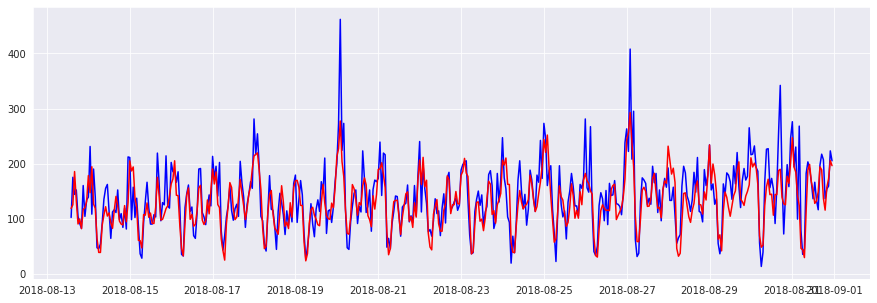

In [277]:
%%time
start_time = time.time()

model = LinearRegression()
model.fit(train_features, train_target)
target_predict = model.predict(test_features)
final_RMSE_LR = mean_squared_error(test_target, target_predict) ** 0.5

plt.figure(figsize=size)
plt.plot(test_target.index, 
         test_target, 
         'b-', 
         test_target.index, 
         target_predict,
         'r-')

current_time = time.time()
LR_fit_t = current_time-start_time
print(final_RMSE_LR)

### Ridge

34.556000878642195
CPU times: user 63.8 ms, sys: 36 ms, total: 99.8 ms
Wall time: 64.2 ms


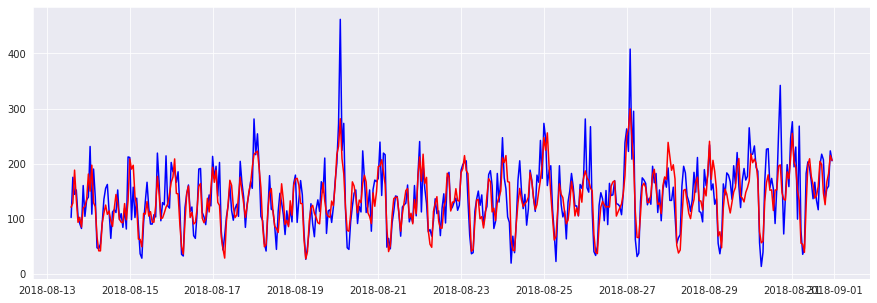

In [278]:
%%time
start_time = time.time()

model = Ridge(random_state=8726)
model.set_params(**best_params_R)
model.fit(train_features, train_target)
target_predict = model.predict(test_features)
final_RMSE_R = mean_squared_error(test_target, target_predict) ** 0.5

plt.figure(figsize=size)
plt.plot(test_target.index, 
         test_target, 
         'b-', 
         test_target.index, 
         target_predict,
         'r-')

current_time = time.time()
R_fit_t = current_time-start_time
print(final_RMSE_R)

### DecisionTreeRegressor

46.62812901337407
CPU times: user 258 ms, sys: 2.98 ms, total: 261 ms
Wall time: 268 ms


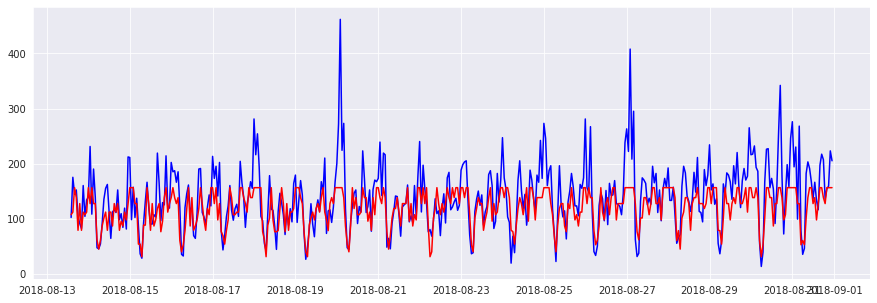

In [279]:
%%time
start_time = time.time()

model = DecisionTreeRegressor(criterion='mse' , random_state=8726)
model.set_params(**best_params_DTR)
model.fit(train_features, train_target)
target_predict = model.predict(test_features)
final_RMSE_DTR = mean_squared_error(test_target, target_predict) ** 0.5

plt.figure(figsize=size)
plt.plot(test_target.index, 
         test_target, 
         'b-', 
         test_target.index, 
         target_predict,
         'r-')

current_time = time.time()
DTR_fit_t = current_time-start_time
print(final_RMSE_DTR)

### Lasso

35.00768780319789
CPU times: user 162 ms, sys: 86 ms, total: 248 ms
Wall time: 142 ms


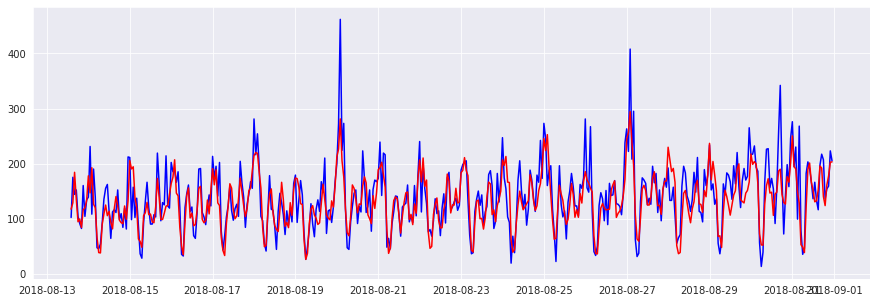

In [280]:
%%time
start_time = time.time()

model = Lasso(normalize=True, random_state=8726)
model.set_params(**best_params_L)
model.fit(train_features, train_target)
target_predict = model.predict(test_features)
final_RMSE_L = mean_squared_error(test_target, target_predict) ** 0.5

plt.figure(figsize=size)
plt.plot(test_target.index, 
         test_target, 
         'b-', 
         test_target.index, 
         target_predict,
         'r-')

current_time = time.time()
L_fit_t = current_time-start_time
print(final_RMSE_L)

### RandomForestRegressor

39.977132369947974
CPU times: user 55.3 s, sys: 70.5 ms, total: 55.3 s
Wall time: 55 s


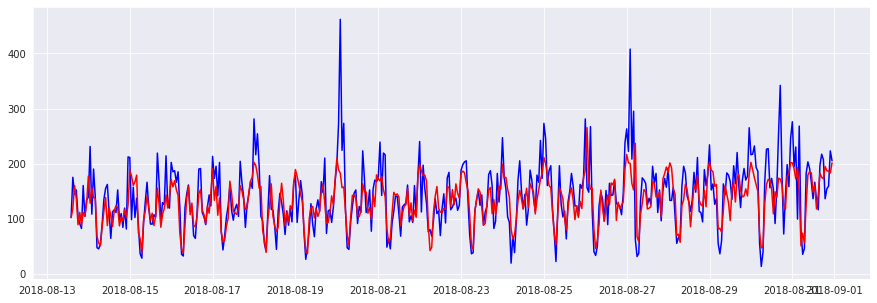

In [281]:
%%time
start_time = time.time()

model = RandomForestRegressor(criterion='mse', random_state=8726)
model.set_params(**best_params_RFR)
model.fit(train_features, train_target)
target_predict = model.predict(test_features)
final_RMSE_RFR = mean_squared_error(test_target, target_predict) ** 0.5

plt.figure(figsize=size)
plt.plot(test_target.index, 
         test_target, 
         'b-', 
         test_target.index, 
         target_predict,
         'r-')

current_time = time.time()
RFR_fit_t = current_time-start_time
print(final_RMSE_RFR)

### CatBoostRegressor

36.96102308787202
CPU times: user 16 s, sys: 186 ms, total: 16.2 s
Wall time: 8.46 s


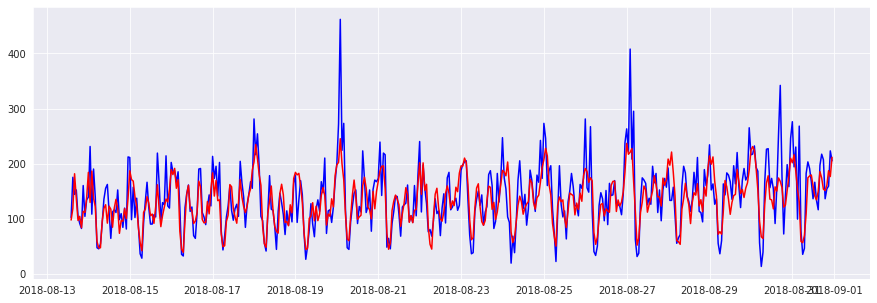

In [282]:
%%time
start_time = time.time()

model = CatBoostRegressor(iterations=200, random_state=8726, verbose=False) 
model.set_params(**best_params_CBR)
model.fit(train_features, train_target)
target_predict = model.predict(test_features)
final_RMSE_CBR = mean_squared_error(test_target, target_predict) ** 0.5

plt.figure(figsize=size)
plt.plot(test_target.index, 
         test_target, 
         'b-', 
         test_target.index, 
         target_predict,
         'r-')

current_time = time.time()
CBR_fit_t = current_time-start_time
print(final_RMSE_CBR)

36.98055942203604
CPU times: user 1min 19s, sys: 765 ms, total: 1min 20s
Wall time: 41.5 s


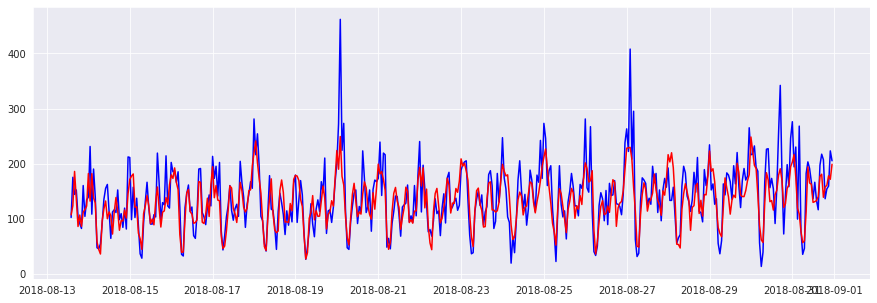

In [283]:
%%time
start_time = time.time()

model = CatBoostRegressor(verbose=False)
model.fit(train_features, train_target)
target_predict = model.predict(test_features)
final_RMSE_CBR_no_params = mean_squared_error(test_target, target_predict) ** 0.5

plt.figure(figsize=size)
plt.plot(test_target.index, 
         test_target, 
         'b-', 
         test_target.index, 
         target_predict,
         'r-')

current_time = time.time()
CBR_np_fit_t = current_time-start_time
print(final_RMSE_CBR_no_params)

### LGBMRegressor

36.7190941736693
CPU times: user 4.73 s, sys: 24.8 ms, total: 4.76 s
Wall time: 2.49 s


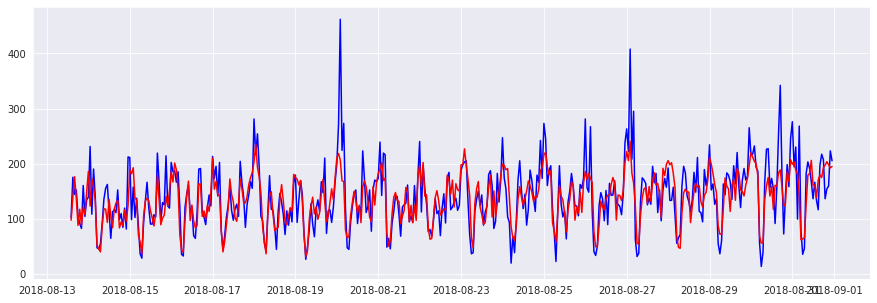

In [284]:
%%time
start_time = time.time()

model = LGBMRegressor()
model.set_params(**best_params_LGBMR)
model.fit(train_features, train_target)
target_predict = model.predict(test_features)
final_RMSE_LGBMR = mean_squared_error(test_target, target_predict) ** 0.5

plt.figure(figsize=size)
plt.plot(test_target.index, 
         test_target, 
         'b-', 
         test_target.index, 
         target_predict,
         'r-')

current_time = time.time()
LGBMR_fit_t = current_time-start_time
print(final_RMSE_LGBMR)

## Итоговый вывод

In [285]:
index = ['LinearRegression',
         'Ridge',
         'DecisionTreeRegressor',
         'Lasso',
         'RandomForestRegressor',
         'CatBoostRegressor',
         'CatBoostRegressor no_parameters',
         'LGBMRegressor',
         'Константная модель']
data = {'Время подбора гиперпараметров, сек':[np.nan,
                                              gcv_RMSE_R_t,
                                              gcv_RMSE_DTR_t,
                                              gcv_RMSE_L_t,
                                              gcv_RMSE_RFR_t,
                                              gcv_RMSE_CBR_t,
                                              np.nan,
                                              gcv_RMSE_LGBMR_t,
                                              np.nan],
        'RMSE на CV':[cv_RMSE_LR,
                      cv_RMSE_R,
                      cv_RMSE_DTR,
                      cv_RMSE_L,
                      cv_RMSE_RFR,
                      cv_RMSE_CBR,
                      cv_RMSE_CBR_no_params,
                      cv_RMSE_LGBMR,
                      final_RMSE_constant],
        'Время обучения на CV, сек':[cv_RMSE_LR_t,
                                     cv_RMSE_R_t,
                                     cv_RMSE_DTR_t,
                                     cv_RMSE_L_t,
                                     cv_RMSE_RFR_t,
                                     cv_RMSE_CBR_t,
                                     cv_RMSE_CBR_no_params_t,
                                     cv_RMSE_LGBMR_t,
                                     RMSE_constant_t],
        'RMSE модели на тестовой выборке':[final_RMSE_LR,
                                           final_RMSE_R,
                                           final_RMSE_DTR,
                                           final_RMSE_L,
                                           final_RMSE_RFR,
                                           final_RMSE_CBR,
                                           final_RMSE_CBR_no_params,
                                           final_RMSE_LGBMR,
                                           final_RMSE_constant],
        'Время обучени - предсказания модели, сек':[LR_fit_t,
                                                    R_fit_t,
                                                    DTR_fit_t,
                                                    L_fit_t,
                                                    RFR_fit_t,
                                                    CBR_fit_t,
                                                    CBR_np_fit_t,
                                                    LGBMR_fit_t,
                                                    RMSE_constant_t]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data['Рейтинг RMSE на CV'] = (scores_data['RMSE на CV'].min() / scores_data['RMSE на CV'])
scores_data['Рейтинг RMSE на тесте'] = (scores_data['RMSE модели на тестовой выборке'].min() / scores_data['RMSE модели на тестовой выборке'])
scores_data['Выполнение задачи'] = scores_data['RMSE модели на тестовой выборке'] < 48.0
scores_data

,"Время подбора гиперпараметров, сек",RMSE на CV,"Время обучения на CV, сек",RMSE модели на тестовой выборке,"Время обучени - предсказания модели, сек",Рейтинг RMSE на CV,Рейтинг RMSE на тесте,Выполнение задачи
LinearRegression,NaN,2.888782e+11,0.732113,35.561178,0.135878,7.437390e-11,0.971734,True
Ridge,43.726200,2.221372e+01,0.685789,34.556001,0.063135,9.671951e-01,1.000000,True
DecisionTreeRegressor,101.023623,2.548019e+01,0.988104,46.628129,0.267443,8.432041e-01,0.741098,True
Lasso,105.753155,2.316076e+01,1.018779,35.007688,0.141842,9.276464e-01,0.987097,True
RandomForestRegressor,88.270110,2.204444e+01,272.910364,39.977132,54.984905,9.746221e-01,0.864394,True
CatBoostRegressor,255.361885,2.223253e+01,63.441633,36.961023,8.461687,9.663766e-01,0.934931,True
CatBoostRegressor no_parameters,NaN,2.161531e+01,312.742285,36.980559,41.509367,9.939716e-01,0.934437,True
LGBMRegressor,469.605505,2.148500e+01,15.568532,36.719094,2.484576,1.000000e+00,0.941091,True
Константная модель,NaN,5.854961e+01,0.004992,58.549609,0.004992,3.669538e-01,0.590200,False


**Вывод**

Во время проекта были изучены способы предсказания веременных рядов С помощью 7ми регрессоров и константной модели.  
Также добавили в список CatBoostRegressor без указания параметров. Регрессор самостоятельно ищет лучшие параметры для выполнения задачи. 

Исходя из финальной таблицы лучше всело предсказала ряд модель Ridge. Это означает, что модель в среднем ошибаетс на 34-35 заказа такси в час. 

По рейтингу на кросс валидации лучше всего себя показал LGBMRegressor. 